Setup and Imports

In [45]:
import os
import numpy as np
import nltk
import json
from sklearn.feature_extraction.text import TfidfVectorizer
from rake_nltk import Rake
import yake
from transformers import pipeline
from sentence_transformers import SentenceTransformer, util
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

nltk_download_path = os.path.join(os.getcwd(), 'NLTK_downloads')
os.makedirs(nltk_download_path, exist_ok=True)

nltk.data.path.append(nltk_download_path)

nltk.download('punkt', download_dir=nltk_download_path)
nltk.download('punkt_tab', download_dir=nltk_download_path)
nltk.download('stopwords', download_dir=nltk_download_path)
nltk.download('wordnet', download_dir=nltk_download_path)
nltk.download('omw-1.4', download_dir=nltk_download_path)

from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package punkt to
[nltk_data]     d:\pythonProject\NLP\NLTK_downloads...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     d:\pythonProject\NLP\NLTK_downloads...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     d:\pythonProject\NLP\NLTK_downloads...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     d:\pythonProject\NLP\NLTK_downloads...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     d:\pythonProject\NLP\NLTK_downloads...
[nltk_data]   Package omw-1.4 is already up-to-date!


Load Text Files

In [30]:
def load_documents_from_folder(file_path):

    documents = []
    for filename in sorted(os.listdir(file_path)):
        if filename.endswith(".txt"):
            with open(os.path.join(file_path, filename), "r", encoding="utf-8") as file:
                documents.append(file.read())
    return documents

documents = load_documents_from_folder('docs')
print("Loaded Documents:")
for i, doc in enumerate(documents):
    print(f"--- Doc {i+1} ---")
    print(doc[:100] + "...") 

Loaded Documents:
--- Doc 1 ---
Well Without Water
Haunted by a running tap in prison, a man grows obsessed with water waste and cli...
--- Doc 2 ---
Around The Pit
Circling billions of gallons of toxic water at America’s largest Superfund site.
by N...


Load Ground Truth

In [31]:
def load_ground_truths_from_folder(file_path):
    
    ground_truths = []
    for filename in sorted(os.listdir(file_path)):
        if filename.endswith(".json"):
            with open(os.path.join(file_path, filename), "r", encoding="utf-8") as file:
                ground_truths.append(json.load(file))
    return ground_truths

ground_truths = load_ground_truths_from_folder('ground_truth')
print("Loaded Ground Truths:")
for i, gt in enumerate(ground_truths):
    print(f"--- Ground Truth {i+1} ---")
    print(gt)


Loaded Ground Truths:
--- Ground Truth 1 ---
['prison', 'incarceration', 'water waste', 'climate change', 'obsession', 'mental health', 'OCD', 'anxiety', 'environmental crisis', 'water scarcity', 'California drought', 'Lake Cachuma', 'veganism', 'parole', 'suicidal ideation', 'shame', 'guilt', 'personal responsibility', 'carceral state', 'environmentalism', 'resource depletion', 'death cleaning', 'system-impacted people', 'rehabilitation', 'second chances', 'hope', 'living with obsession', 'the Anthropocene', 'moral responsibility', 'existential dread']
--- Ground Truth 2 ---
['Superfund site', 'toxic water', 'Berkeley Pit', 'Butte Montana', 'environmental disaster', 'mining', 'copper mine', 'Atlantic Richfield Company (ARCO)', 'snow geese die-off', 'hydrological cycle', 'Silver Bow Creek', 'Continental Divide', 'slag', 'mining byproducts', 'Anaconda Copper Company', 'copper kings', 'Granite Mountain mine disaster', 'Speculator mine disaster', 'labor unionism', 'Frank Little', 'open-pi

Preprocessing

In [32]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    tokens = nltk.word_tokenize(text.lower())
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalpha() and word not in stop_words]
    return ' '.join(tokens)

processed_docs = [preprocess(doc) for doc in documents]
ground_truths = load_ground_truths_from_folder('NLTK_downloads/token')
print("\nProcessed Documents (first document shown):")
print(processed_docs[0][:1000] + "...")


Processed Documents (first document shown):
well without water haunted running tap prison man grows obsessed water waste climate change pushing edge michael fischer april water pouring prison cell barred window became insufferable type person know take gallon water produce single almond twentysomething state prison inmate listening sound running faucet picture prison dorm upstate new york long room high ceiling filled row sloppily painted cubicle one big enough metal bunk oversized locker handmade mousetrap rigged peanut butter bide time buffed linoleum industrial fan mounted one corner blow smell sweat floor polish around room correctional officer desk sits platform next doorway lead dayroom two phone bathroom prison bathroom often folk inside call heinie hiders partition rise even inmate shoulder seated freezing stainless steel toilet pretty good livingston bathroom stall almost normal except door two foot short anyone walking could look onto security course hang towel stall top bar

Keyword Extraction

In [33]:
def tfidf_keywords(docs, top_n=30):
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(docs)
    keywords_per_doc = []
    for row in X:
        scores = zip(vectorizer.get_feature_names_out(), row.toarray()[0])
        sorted_keywords = sorted(scores, key=lambda x: x[1], reverse=True)
        keywords_per_doc.append([kw for kw, _ in sorted_keywords[:top_n]])
    return keywords_per_doc

def rake_keywords(docs, top_n=30):
    rake = Rake()
    keywords_all = []
    for doc in docs:
        rake.extract_keywords_from_text(doc)
        keywords = rake.get_ranked_phrases()[:top_n]
        keywords_all.append(keywords)
    return keywords_all

def yake_keywords(docs, top_n=30):
    kw_extractor = yake.KeywordExtractor(top=top_n)
    return [[kw for kw, _ in kw_extractor.extract_keywords(doc)] for doc in docs]

def bert_keywords(docs, top_n=30):
    model = SentenceTransformer('all-MiniLM-L6-v2')
    keywords_all = []
    for doc in docs:
        candidate_words = list(set([word for word in doc.split() if len(word) > 3]))
        doc_emb = model.encode(doc, convert_to_tensor=True)
        word_embs = model.encode(candidate_words, convert_to_tensor=True)
        cosine_scores = util.cos_sim(word_embs, doc_emb)
        top_results = cosine_scores.squeeze().topk(top_n)
        keywords = [candidate_words[i] for i in top_results.indices]
        keywords_all.append(keywords)
    return keywords_all

Extractive Summary

In [34]:
def extractive_summary(doc, keywords, num_sentences=10):
    sentences = sent_tokenize(doc)
    ranked = sorted(sentences, key=lambda s: sum(word.lower() in s.lower() for word in keywords), reverse=True)
    return ' '.join(ranked[:num_sentences])

Run All Methods

In [35]:
methods = {
    "TF-IDF": tfidf_keywords,
    "RAKE": rake_keywords,
    "YAKE": yake_keywords,
    "BERT": bert_keywords
}

results = []
summaries = {}

for name, method in methods.items():
    keywords = method(processed_docs if name != "RAKE" else documents) # RAKE works on raw text
    summaries[name] = [extractive_summary(doc, kw) for doc, kw in zip(documents, keywords)]
    for i, kw in enumerate(keywords):
        results.append({"Method": name, "Doc": f"Doc {i+1}", "Keywords": ", ".join(kw)})

Visualization

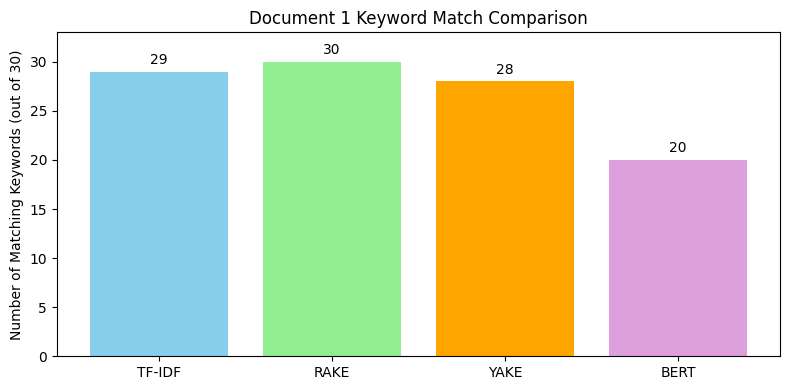

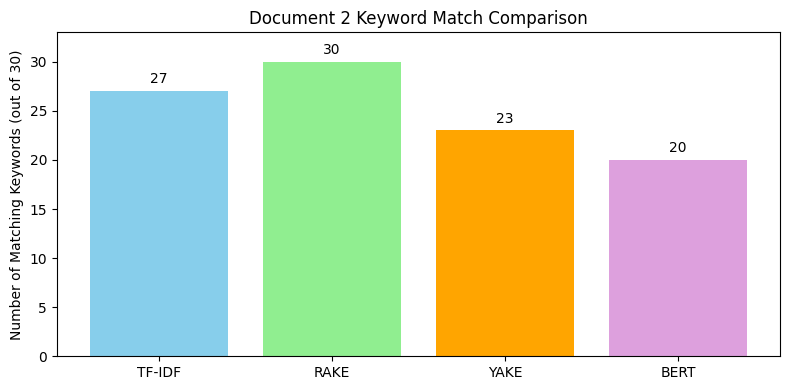

In [36]:
def count_matches(extracted, ground_truth):
    return len(set(map(str.lower, extracted)) & set(map(str.lower, ground_truth)))

def plot_matches_per_doc(ground_truths, tfidf_kw, rake_kw, yake_kw, bert_kw):
    methods = ['TF-IDF', 'RAKE', 'YAKE', 'BERT']
    for i in range(len(ground_truths)):
        matches = [
            count_matches(tfidf_kw[i], ground_truths[i]),
            count_matches(rake_kw[i], ground_truths[i]),
            count_matches(yake_kw[i], ground_truths[i]),
            count_matches(bert_kw[i], ground_truths[i])
        ]
        
        plt.figure(figsize=(8, 4))
        bars = plt.bar(methods, matches, color=['skyblue', 'lightgreen', 'orange', 'plum'])
        plt.title(f'Document {i + 1} Keyword Match Comparison')
        plt.ylabel('Number of Matching Keywords (out of 30)')
        plt.ylim(0, 33)
        
        for bar, count in zip(bars, matches):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, str(count),
                     ha='center', va='bottom', fontsize=10)
        
        plt.tight_layout()
        plt.show()

plot_matches_per_doc(ground_truths, tfidf_keywords(documents), rake_keywords(documents), yake_keywords(documents), bert_keywords(documents))


Print Summaries

In [38]:
output_dir = 'summaries'
os.makedirs(output_dir, exist_ok=True)

for method, summary_list in summaries.items():
    method_dir = os.path.join(output_dir, method.replace(" ", "_"))
    os.makedirs(method_dir, exist_ok=True)
    print(f"\n--- Saving {method} Summaries ---")
    for i, summ in enumerate(summary_list):
        filename = f"doc-{i+1}_summary.txt"
        filepath = os.path.join(method_dir, filename)
        with open(filepath, "w", encoding="utf-8") as f:
            f.write(summ)
        print(f"Saved Doc {i+1} summary to: {filepath}")


--- Saving TF-IDF Summaries ---
Saved Doc 1 summary to: summaries\TF-IDF\doc-1_summary.txt
Saved Doc 2 summary to: summaries\TF-IDF\doc-2_summary.txt

--- Saving RAKE Summaries ---
Saved Doc 1 summary to: summaries\RAKE\doc-1_summary.txt
Saved Doc 2 summary to: summaries\RAKE\doc-2_summary.txt

--- Saving YAKE Summaries ---
Saved Doc 1 summary to: summaries\YAKE\doc-1_summary.txt
Saved Doc 2 summary to: summaries\YAKE\doc-2_summary.txt

--- Saving BERT Summaries ---
Saved Doc 1 summary to: summaries\BERT\doc-1_summary.txt
Saved Doc 2 summary to: summaries\BERT\doc-2_summary.txt


Compare Summarization

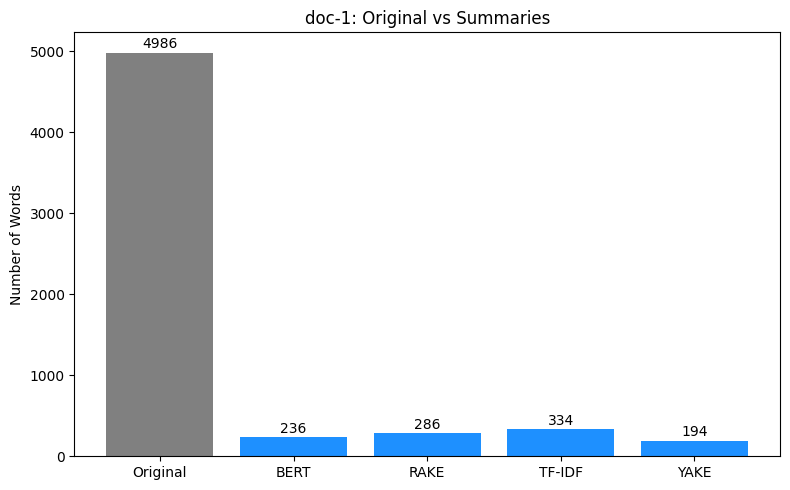

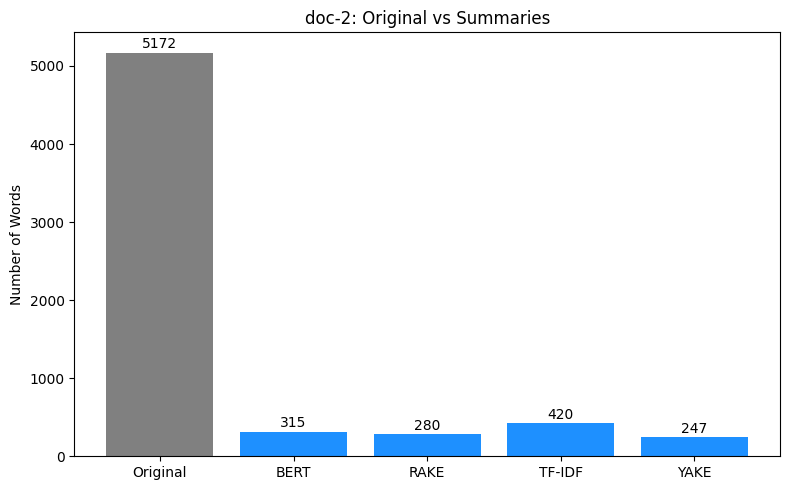

In [50]:
def read_file(filepath):
    with open(filepath, 'r', encoding='utf-8') as f:
        return f.read()

def count_words(text):
    return len(text.split())

# Filepaths
files = {
    'doc-1': 'docs/doc-1.txt',
    'doc-2': 'docs/doc-2.txt',
    'doc-1b': 'summaries/BERT/doc-1_summary.txt',
    'doc-2b': 'summaries/BERT/doc-2_summary.txt',
    'doc-1r': 'summaries/RAKE/doc-1_summary.txt',
    'doc-2r': 'summaries/RAKE/doc-2_summary.txt',
    'doc-1t': 'summaries/TF-IDF/doc-1_summary.txt',
    'doc-2t': 'summaries/TF-IDF/doc-2_summary.txt',
    'doc-1y': 'summaries/YAKE/doc-1_summary.txt',
    'doc-2y': 'summaries/YAKE/doc-2_summary.txt',
}

methods = ['Original', 'BERT', 'RAKE', 'TF-IDF', 'YAKE']
colors = ['gray', 'dodgerblue', 'dodgerblue', 'dodgerblue', 'dodgerblue']

def plot_doc_summary(doc_key, summary_keys, title):
    orig_len = count_words(read_file(files[doc_key]))
    summary_lens = [count_words(read_file(files[k])) for k in summary_keys]
    
    values = [orig_len] + summary_lens
    x = np.arange(len(methods))

    fig, ax = plt.subplots(figsize=(8, 5))
    bars = ax.bar(x, values, color=colors)

    ax.set_title(title)
    ax.set_ylabel('Number of Words')
    ax.set_xticks(x)
    ax.set_xticklabels(methods)

    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height}',
                    xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 1),
                    textcoords='offset points',
                    ha='center', va='bottom')

    fig.tight_layout()
    plt.show()

# Plot for doc-1
plot_doc_summary('doc-1', ['doc-1b', 'doc-1r', 'doc-1t', 'doc-1y'], 'doc-1: Original vs Summaries')

# Plot for doc-2
plot_doc_summary('doc-2', ['doc-2b', 'doc-2r', 'doc-2t', 'doc-2y'], 'doc-2: Original vs Summaries')

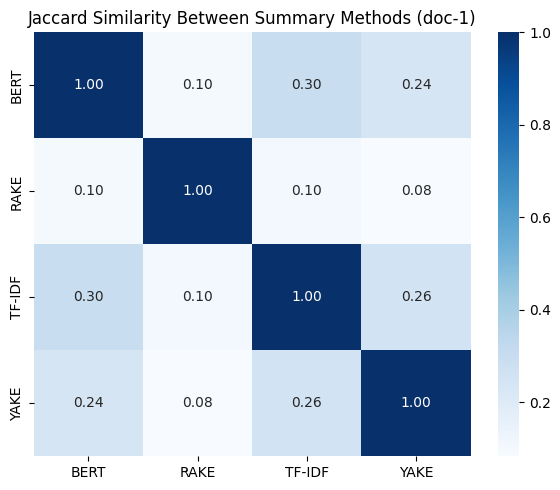

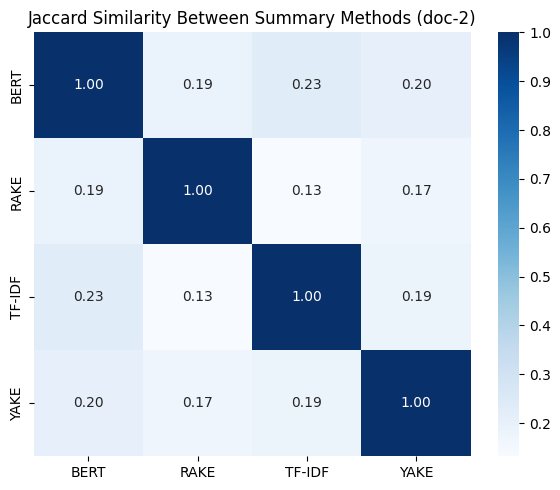

In [52]:
def read_file(filepath):
    with open(filepath, 'r', encoding='utf-8') as f:
        return f.read()

def jaccard_similarity(text1, text2):
    set1 = set(text1.lower().split())
    set2 = set(text2.lower().split())
    intersection = set1.intersection(set2)
    union = set1.union(set2)
    return len(intersection) / len(union) if union else 0

# Filepaths for doc-1 and doc-2 summaries
summ_files_doc1 = {
    'BERT': 'summaries/BERT/doc-1_summary.txt',
    'RAKE': 'summaries/RAKE/doc-1_summary.txt',
    'TF-IDF': 'summaries/TF-IDF/doc-1_summary.txt',
    'YAKE': 'summaries/YAKE/doc-1_summary.txt'
}

summ_files_doc2 = {
    'BERT': 'summaries/BERT/doc-2_summary.txt',
    'RAKE': 'summaries/RAKE/doc-2_summary.txt',
    'TF-IDF': 'summaries/TF-IDF/doc-2_summary.txt',
    'YAKE': 'summaries/YAKE/doc-2_summary.txt'
}

# Load summaries
summ_texts_doc1 = {label: read_file(path) for label, path in summ_files_doc1.items()}
summ_texts_doc2 = {label: read_file(path) for label, path in summ_files_doc2.items()}
labels_doc1 = list(summ_texts_doc1.keys())
labels_doc2 = list(summ_texts_doc2.keys())

# Compute Jaccard similarity matrices
def compute_similarity_matrix(summ_texts, labels):
    n = len(labels)
    similarity_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            similarity_matrix[i][j] = jaccard_similarity(summ_texts[labels[i]], summ_texts[labels[j]])
    return similarity_matrix

similarity_matrix_doc1 = compute_similarity_matrix(summ_texts_doc1, labels_doc1)
similarity_matrix_doc2 = compute_similarity_matrix(summ_texts_doc2, labels_doc2)

# Plot heatmaps
def plot_similarity_heatmap(similarity_matrix, labels, title):
    plt.figure(figsize=(6, 5))
    sns.heatmap(similarity_matrix, xticklabels=labels, yticklabels=labels, annot=True, cmap='Blues', fmt=".2f")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Plot for doc-1
plot_similarity_heatmap(similarity_matrix_doc1, labels_doc1, "Jaccard Similarity Between Summary Methods (doc-1)")

# Plot for doc-2
plot_similarity_heatmap(similarity_matrix_doc2, labels_doc2, "Jaccard Similarity Between Summary Methods (doc-2)")

